
# Smartvote – Clustering Pipeline  


In [21]:

from pathlib import Path
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer, util
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
import nltk, sys, warnings, math

import math, itertools
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter

# ---------- Parameter ----------
DATA_PATH              = Path('df_de_final.xlsx')       # Eingabedatei
EXPORT_PATH            = Path('cluster_ergebnis.xlsx')  # Ausgabe‑Datei

SBERT_MODEL_NAME       = 'paraphrase-multilingual-MiniLM-L12-v2'

# Clustering
HDBSCAN_MIN_CLUSTER_SIZE = 2
HDBSCAN_MIN_SAMPLES      = None        # None = auto = min_cluster_size//2
MIN_FINAL_CLUSTER_SIZE   = 2           # alles <2 wird als Noise behandelt

# Duplikaterkennung
DUP_EPS = 0.05                         # DBSCAN‑Epsilon im TF‑IDF‑Raum

# Re‑Assignment
REASSIGN_SIM_THRESH = 0.70             # Schwelle, ab der Noise‑Fragen einem Cluster zugeordnet werden

# NLTK‐Stopwörter laden (nur 1× pro Session)
nltk.download('stopwords', quiet=True)
GERMAN_STOP = stopwords.words('german')

print('Parameter geladen.')


Parameter geladen.


In [22]:

# 1 ) Daten laden & Grundreinigung
df_all = pd.read_excel(DATA_PATH)
print(f'Geladene Zeilen: {len(df_all):,}')

df_all['frage_text_norm'] = (
    df_all['Frage_Text'].astype(str)
          .str.strip()
          .str.lower()
)

print('Norm‑Spalte fertig.')


Geladene Zeilen: 7,459
Norm‑Spalte fertig.


In [23]:

# 2 ) Duplikaterkennung mit TF‑IDF + DBSCAN
tfidf  = TfidfVectorizer(stop_words=GERMAN_STOP)
X_tfidf = tfidf.fit_transform(df_all['frage_text_norm'])

dbscan = DBSCAN(eps=DUP_EPS, min_samples=2, metric='cosine')
dupe_labels = dbscan.fit_predict(X_tfidf)

df_all['dupe_cluster']  = dupe_labels
df_all['dupe_is_main']  = df_all.groupby('dupe_cluster').cumcount() == 0

# --- Repräsentanten auswählen & eindeutige Fragen extrahieren ---
unique_mask = (df_all['dupe_cluster'] == -1) | (df_all['dupe_is_main'])
df_unique   = df_all[unique_mask].copy().reset_index(drop=True)

print(f'Eindeutige Fragen nach Duplikaterkennung: {len(df_unique):,}')


Eindeutige Fragen nach Duplikaterkennung: 2,955


In [24]:

# 3 ) SBERT‑Embeddings berechnen
model = SentenceTransformer(SBERT_MODEL_NAME)
embeddings = model.encode(
    df_unique['frage_text_norm'].tolist(),
    show_progress_bar=True,
    convert_to_tensor=True
)
print('Embeddings erstellt.')


Batches:   0%|          | 0/93 [00:00<?, ?it/s]

Embeddings erstellt.


In [25]:

# 4 ) HDBSCAN‑Clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size      = HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples           = HDBSCAN_MIN_SAMPLES,
    metric                = 'euclidean',
    cluster_selection_method = 'eom'
)
cluster_labels = clusterer.fit_predict(embeddings.cpu().numpy())
df_unique['cluster'] = cluster_labels

print('Anzahl Cluster (exkl. Noise):',
      len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))


c:\Users\olive\git\EPRP\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\olive\git\EPRP\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Anzahl Cluster (exkl. Noise): 276


In [26]:

# 5 ) Ein‑Fragen‑Cluster als Noise behandeln
size_map = df_unique.groupby('cluster').size()
tiny_clusters = size_map[size_map < MIN_FINAL_CLUSTER_SIZE].index

df_unique.loc[df_unique['cluster'].isin(tiny_clusters), 'cluster'] = -1
print(f'Als Noise markiert (Grösse <{MIN_FINAL_CLUSTER_SIZE}): {len(tiny_clusters)} Cluster')


Als Noise markiert (Grösse <2): 0 Cluster


In [27]:

# 6 ) Noise‑Punkte zuordnen
import torch
noise_idx = df_unique[df_unique['cluster'] == -1].index

if len(noise_idx):
    noise_emb = embeddings[noise_idx]
    clustered_mask = df_unique['cluster'] != -1
    clustered_emb  = embeddings[clustered_mask]

    for i, idx in enumerate(noise_idx):
        sims = util.cos_sim(noise_emb[i], clustered_emb)[0].cpu().numpy()
        best_idx   = sims.argmax()
        best_sim   = sims[best_idx]

        if best_sim >= REASSIGN_SIM_THRESH:
            best_cluster = df_unique.iloc[np.where(clustered_mask)[0][best_idx]]['cluster']
            # -------- sauberes noise‑Label ohne Verdopplung -----------
            if isinstance(best_cluster, str) and best_cluster.startswith('noise_'):
                base = best_cluster.split('noise_')[-1]
                df_unique.at[idx, 'cluster'] = f'noise_{base}'
            else:
                df_unique.at[idx, 'cluster'] = f'noise_{best_cluster}'

print('Noise‑Reassignment abgeschlossen.')


C:\Users\olive\AppData\Local\Temp\ipykernel_26140\2995201860.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'noise_196' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_unique.at[idx, 'cluster'] = f'noise_{best_cluster}'


Noise‑Reassignment abgeschlossen.


In [28]:

# 7 ) Hauptfrage & Ähnlichkeit
df_unique['ist_hauptfrage']              = False
df_unique['ähnlichkeit_zur_hauptfrage']  = np.nan

final_emb = model.encode(df_unique['frage_text_norm'].tolist(),
                         convert_to_tensor=True)

for cl in df_unique['cluster'].unique():
    cl_mask = df_unique['cluster'] == cl
    idxs    = np.where(cl_mask)[0]
    if not len(idxs):
        continue
    centroid = final_emb[idxs].mean(dim=0, keepdim=True)
    sims     = util.cos_sim(centroid, final_emb[idxs])[0].cpu().numpy()

    best_local_idx = idxs[sims.argmax()]
    df_unique.at[best_local_idx, 'ist_hauptfrage'] = True
    df_unique.loc[cl_mask, 'ähnlichkeit_zur_hauptfrage'] = sims

print('Hauptfragen markiert & Ähnlichkeiten berechnet.')


Hauptfragen markiert & Ähnlichkeiten berechnet.


In [29]:

# 8 ) Cluster auf alle Duplikats‑Zeilen übertragen
# 8a) Cluster‑Info von df_unique an df_all mergen
df_all = df_all.merge(
    df_unique[['ID_gesamt', 'cluster']],
    on='ID_gesamt',
    how='left'
)

# 8b) Fehlende Cluster über Repräsentanten‑Map auffüllen
rep_map = (df_all[df_all['dupe_is_main']]
           .set_index('dupe_cluster')['cluster'])

def fill_cluster(row):
    if pd.isna(row['cluster']):
        return rep_map.get(row['dupe_cluster'], -1)
    return row['cluster']

df_all['cluster'] = df_all.apply(fill_cluster, axis=1)

print('Cluster auf alle Zeilen übertragen.')


Cluster auf alle Zeilen übertragen.


In [30]:
# 9) Hauptfrage-Similarität, identische-Cluster zu -1, Noise-Sortierung -----
from pathlib import Path
import numpy as np, torch, pandas as pd
from sentence_transformers import util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils import get_column_letter

EXPORT_PATH = Path('cluster_ergebnis.xlsx')

export_cols = ['cluster',
               'ist_hauptfrage',
               'ähnlichkeit_zur_hauptfrage',
               'Frage_Text',
               'ID_gesamt']

# ---------------------------------------------------------------------------
# 9a) Grundspalten sicherstellen
for col in ['ist_hauptfrage', 'ähnlichkeit_zur_hauptfrage']:
    if col not in df_all.columns:
        df_all[col] = False if col == 'ist_hauptfrage' else np.nan

if ('frage_text_norm' not in df_all.columns or
        df_all['frage_text_norm'].isna().all()):
    df_all['frage_text_norm'] = (
        df_all['Frage_Text'].astype(str).str.strip().str.lower()
    )

df_export = df_all[export_cols + ['frage_text_norm']].copy()

# ---------------------------------------------------------------------------
# 9b) Noise-Subcluster mit nur 1 Frage zu -1
sizes = df_export.groupby('cluster').size()
single_noise = [c for c, n in sizes.items() if (n == 1) and str(c).startswith('noise')]
if single_noise:
    df_export.loc[df_export['cluster'].isin(single_noise), 'cluster'] = -1

# ---------------------------------------------------------------------------
# 9c) Embeddings + Ähnlichkeit zur **Hauptfrage**
emb = model.encode(df_export['frage_text_norm'].tolist(), convert_to_tensor=True)
df_export[['ähnlichkeit_zur_hauptfrage', 'ist_hauptfrage']] = [np.nan, False]

clusters_to_noise = []   # merken, ob alle Fragen identisch sind

for cl in df_export['cluster'].unique():
    if cl == -1:
        continue

    idxs = np.where(df_export['cluster'] == cl)[0]
    if len(idxs) == 0:
        continue

    emb_cl = emb[idxs]

    # Hauptfrage = Text mit höchster Frequenz; bei Gleichstand beste zum Zentroid
    texts = df_export.loc[idxs, 'frage_text_norm']
    counts = texts.value_counts()
    most_freq = counts.index[0]
    cand_idxs = idxs[texts == most_freq]

    if len(cand_idxs) == 1:
        main_idx = cand_idxs[0]
    else:
        # mehrere gleich häufig -> wähle die, die dem Zentroid am nächsten ist
        centroid = emb_cl.mean(dim=0, keepdim=True)
        sims_tmp = util.cos_sim(centroid, emb[cand_idxs])[0]
        main_idx = cand_idxs[int(sims_tmp.argmax())]

    main_emb = emb[main_idx]

    # Ähnlichkeitsmatrix zur Hauptfrage
    sims = util.cos_sim(main_emb, emb_cl)[0].cpu().numpy()

    # identischer Text => 1.0
    main_text = df_export.at[main_idx, 'frage_text_norm']
    for i, idx in enumerate(idxs):
        if df_export.at[idx, 'frage_text_norm'] == main_text:
            sims[i] = 1.0

    df_export.loc[idxs, 'ähnlichkeit_zur_hauptfrage'] = sims
    df_export.at[main_idx, 'ist_hauptfrage'] = True
    df_export.at[main_idx, 'ähnlichkeit_zur_hauptfrage'] = 1.0

    # prüfen, ob ALLE Fragen identisch (sim==1)
    if np.allclose(sims, 1.0):
        clusters_to_noise.append(cl)

# 9d) identische-Cluster zu -1
if clusters_to_noise:
    df_export.loc[df_export['cluster'].isin(clusters_to_noise), 'cluster'] = -1
    print(f"→ {len(clusters_to_noise)} identische Cluster nach -1 verschoben")

# ---------------------------------------------------------------------------
# 9e) Cluster-Reihenfolge (normale, noise_sub)  – nach Grösse
sizes = (df_export[df_export['cluster'] != -1]
         .groupby('cluster').size()
         .sort_values(ascending=False))
normal_clusters = [c for c in sizes.index if not str(c).startswith('noise')]
noise_sub       = [c for c in sizes.index if str(c).startswith('noise')]
order_all       = normal_clusters + noise_sub      # -1 folgt später

# ---------------------------------------------------------------------------
# 9f) Noise-Fragen (-1) gruppieren & nach Gruppengrösse sortieren
noise_df = df_export[df_export['cluster'] == -1].copy()
noise_groups = {}
if len(noise_df):
    tfidf_vec = TfidfVectorizer(stop_words=None)
    X_tfidf   = tfidf_vec.fit_transform(noise_df['frage_text_norm'])
    dbscan    = DBSCAN(eps=0.05, min_samples=1, metric='cosine')
    ng_labels = dbscan.fit_predict(X_tfidf)
    noise_df['noise_group'] = ng_labels
    # noise_group zurück in df_export übernehmen
    df_export.loc[noise_df.index, 'noise_group'] = noise_df['noise_group']


    # Gruppen dict, sortiert nach Grösse absteigend
    grp_sizes = noise_df.groupby('noise_group').size().sort_values(ascending=False)
    for g in grp_sizes.index:
        noise_groups[int(g)] = noise_df[noise_df['noise_group'] == g]

# ---------------------------------------------------------------------------
# 9g) Excel-Export
wb = Workbook()
ws = wb.active
ws.title = 'Cluster'

# Kopfzeile
for c_idx, col in enumerate(export_cols, 1):
    ws.cell(row=1, column=c_idx, value=col)

YELLOW  = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")
sim_col = export_cols.index('ähnlichkeit_zur_hauptfrage') + 1
row_ptr = 2   # Zeile nach Header

def write_block(start_row: int, df_block: pd.DataFrame, label: str) -> int:
    """Schreibt Überschrift + Zeilen, gibt neue Zeilen­nummer zurück."""
    row = start_row
    ws.cell(row=row, column=1, value=f"{label} enthält {len(df_block)} Fragen")
    row += 1

    df_sorted = (df_block
                 .sort_values(['ist_hauptfrage',
                               'ähnlichkeit_zur_hauptfrage'],
                              ascending=[False, False])
                 [export_cols])

    for _, r in df_sorted.iterrows():
        for c_idx, col in enumerate(export_cols, 1):
            val = r[col]
            ws.cell(row=row, column=c_idx, value=val)
            if (c_idx == sim_col) and pd.notna(val) and (val < 1):
                ws.cell(row=row, column=c_idx).fill = YELLOW
        row += 1
    return row + 1   # Leerzeile danach

# normale + noise-sub
for cl in order_all:
    row_ptr = write_block(row_ptr,
                          df_export[df_export['cluster'] == cl],
                          f"Cluster {cl}")

# Noise (-1) nach Gruppen
if noise_groups:
    ws.cell(row=row_ptr, column=1,
            value=f"Ungeclusterte Noise-Fragen (-1): {len(noise_df)}")
    row_ptr += 1
    for grp_id, grp_df in noise_groups.items():
        row_ptr = write_block(row_ptr, grp_df, f"Noise-Gruppe {grp_id}")

# Auto-Filter & Spaltenbreite
ws.auto_filter.ref = f"A1:{get_column_letter(len(export_cols))}{row_ptr}"
for c_idx in range(1, len(export_cols) + 1):
    ws.column_dimensions[get_column_letter(c_idx)].width = 22

wb.save(EXPORT_PATH)
print(f"✓ Export fertig: {EXPORT_PATH}")


→ 25 identische Cluster nach -1 verschoben
✓ Export fertig: cluster_ergebnis.xlsx


Normale Cluster:              276
Noise-Subcluster:             199
Noise-Gruppen in Cluster -1:  336


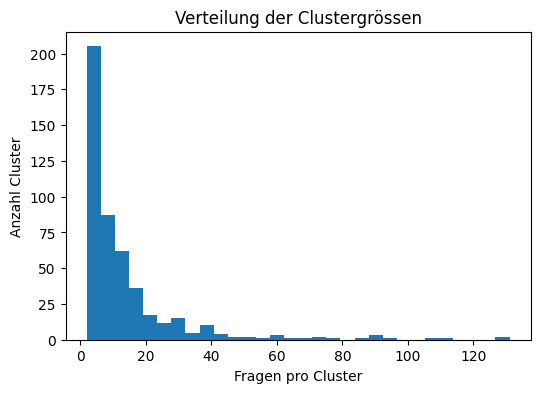

,Fragen
cluster,
48,131
110,130
31,111
165,107
81,94
219,89
69,89
111,88
noise_100,84


len n_total: 7459
len n_noise: 990
Anteil unbearbeiteter Noise-Fragen: 13.3%
Ø Ähnlichkeit (Median aller Cluster): 0.909


In [31]:
# --- Block 10: Cluster-Analyse ------------------------------------------------
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# 1) Normale Cluster (alle Integer ≠ -1, die NICHT mit "noise_" beginnen)
normal_clusters = [
    c for c in df_export["cluster"].unique()
    if c != -1 and not (isinstance(c, str) and c.startswith("noise"))
]
n_normal = len(normal_clusters)

# 2) Nachträglich gebildete Noise-Subcluster  ("noise_<basis-cluster>")
noise_subclusters = [
    c for c in df_export["cluster"].unique()
    if isinstance(c, str) and c.startswith("noise")
]
n_noise_sub = len(noise_subclusters)

# 3) Noise-Gruppen innerhalb des echten Noise-Clusters (-1)
if "noise_group" in df_export.columns:
    n_noise_groups = df_export.loc[df_export["cluster"] == -1, "noise_group"].nunique()
else:
    n_noise_groups = 0  # Falls 9f noch nicht gelaufen ist

print(f"Normale Cluster:              {n_normal}")
print(f"Noise-Subcluster:             {n_noise_sub}")
print(f"Noise-Gruppen in Cluster -1:  {n_noise_groups}")

# --------------------------------------------------------------------------- #
# Zusätzliche, optionale Auswertungen --------------------------------------- #

# a) Verteilung der Clustergrössen
sizes = df_export[df_export["cluster"] != -1].groupby("cluster").size()
plt.figure(figsize=(6,4))
plt.hist(sizes, bins=30)
plt.title("Verteilung der Clustergrössen")
plt.xlabel("Fragen pro Cluster")
plt.ylabel("Anzahl Cluster")
plt.show()

# b) Top-10 grösste Cluster
top10 = sizes.sort_values(ascending=False).head(10)
display(top10.to_frame("Fragen").style.background_gradient(axis=0, cmap="Greens"))

# c) Anteil Noise-Fragen insgesamt
n_total   = len(df_export)
n_noise   = (df_export["cluster"] == -1).sum()
print(f"len n_total: {n_total}")
print(f"len n_noise: {n_noise}")
print(f"Anteil unbearbeiteter Noise-Fragen: {n_noise/n_total:.1%}")

# d) Durchschnittliche Ähnlichkeit innerhalb jedes Clusters
mean_sim = (df_export
            .dropna(subset=["ähnlichkeit_zur_hauptfrage"])
            .groupby("cluster")["ähnlichkeit_zur_hauptfrage"]
            .mean())
print(f"Ø Ähnlichkeit (Median aller Cluster): {mean_sim.median():.3f}")
